In [1]:
#Import Dependencies 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter
import scipy as sp

from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.preprocessing import QuantileTransformer,StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import TransformedTargetRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
import seaborn as sns
sns.set()

In [3]:
# Read the csv data and drop non-essantial columns.

df=pd.read_csv("Data/train.csv")
df.drop(['policy_id','area_cluster','length','width','height','gross_weight','displacement','turning_radius','is_front_fog_lights','is_rear_window_wiper'], axis=1,inplace=True)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
1,0.672619,0.02,0.375000,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
2,0.841110,0.02,0.384615,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
3,0.900277,0.11,0.432692,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,0.596403,0.11,0.634615,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [4]:
# Check for unique values in the data.
# This can help us to visualize and separate classification columns and continuous columns.
df.nunique()

policy_tenure                       58591
age_of_car                             49
age_of_policyholder                    75
population_density                     22
make                                    5
segment                                 6
model                                  11
fuel_type                               3
max_torque                              9
max_power                               9
engine_type                            11
airbags                                 3
is_esc                                  2
is_adjustable_steering                  2
is_tpms                                 2
is_parking_sensors                      2
is_parking_camera                       2
rear_brakes_type                        2
cylinder                                2
transmission_type                       2
gear_box                                2
steering_type                           3
is_rear_window_washer                   2
is_rear_window_defogger           

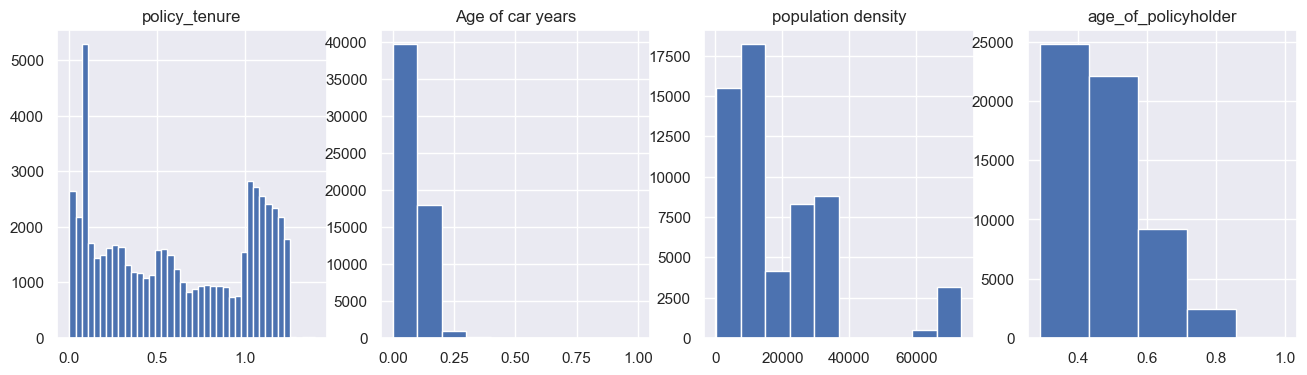

In [5]:
# Data distribution visualizations

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 4))
ax0.set_title("policy_tenure")
_ = df["policy_tenure"].hist(bins=40, ax=ax0)
ax1.set_title("Age of car years")
_ = df["age_of_car"].hist(bins=10,  ax=ax1)
ax2.set_title("population density")
_ = df["population_density"].hist(bins=10, ax=ax2)
ax3.set_title("age_of_policyholder")
_ = df["age_of_policyholder"].hist(bins=5, ax=ax3)



In [6]:
# Print high risk and low risk customers percentage

claims=Counter(df['is_claim'])
print(
    "Fraction of low-risk customers = {0:.1%}".format(
        claims[0] / (claims[0]+claims[1]))
    )
print(
    "Fraction of high risk customers = {0:.1%}".format(
        claims[1] / (claims[0]+claims[1]))
    )

Fraction of low-risk customers = 93.6%
Fraction of high risk customers = 6.4%


In [7]:
print(
    "Average Frequency = {}".format(np.average(df["is_claim"]))
)

Average Frequency = 0.06396777717094485


In [8]:
# Create our features
X=df.drop('is_claim',axis=1)

# Create our target
y = df['is_claim']

In [9]:
# Get the list of all object type columns and plan our encoding strategy.
column_list = list(X.select_dtypes(include=['O']).columns)
column_list

['segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [10]:
# As all the columns starts with "is_" are YES/NO columns.
# As per our encoding sttategy,we sepatated binary columns from column_list
import re
binary_cols=[cols for cols in column_list if re.search(r'^is_',cols)]
binary_cols

['is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [11]:
# Perform label encoding on binary columns which converts YES/NO into 1/0 respectively .
le = LabelEncoder()
for col in binary_cols:
    X[col] = le.fit_transform(X[col])
X.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,0.515874,0.05,0.644231,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
1,0.672619,0.02,0.375000,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
2,0.841110,0.02,0.384615,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
3,0.900277,0.11,0.432692,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,1,1,1,1,1,1,1,1,1,2
4,0.596403,0.11,0.634615,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,0,0,1,1,1,0,1,1,1,2


# Phase 1- As is

In this phase,we will do label encoding on remaining columns and check out model scores and confusion matrix.

In [12]:
X_phase1=X.copy()

In [13]:
column_list = list(X_phase1.select_dtypes(include=['O']).columns)
column_list

['segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'rear_brakes_type',
 'transmission_type',
 'steering_type']

In [14]:
for col in column_list:
    X_phase1[col] = le.fit_transform(X_phase1[col])
X_phase1.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,0.515874,0.05,0.644231,4990,1,0,0,0,5,2,...,0,0,0,0,1,0,0,0,1,0
1,0.672619,0.02,0.375000,27003,1,0,0,0,5,2,...,0,0,0,0,1,0,0,0,1,0
2,0.841110,0.02,0.384615,4076,1,0,0,0,5,2,...,0,0,0,0,1,0,0,0,1,0
3,0.900277,0.11,0.432692,21622,1,3,3,2,0,6,...,1,1,1,1,1,1,1,1,1,2
4,0.596403,0.11,0.634615,34738,2,0,4,2,8,5,...,0,0,1,1,1,0,1,1,1,2


<AxesSubplot: >

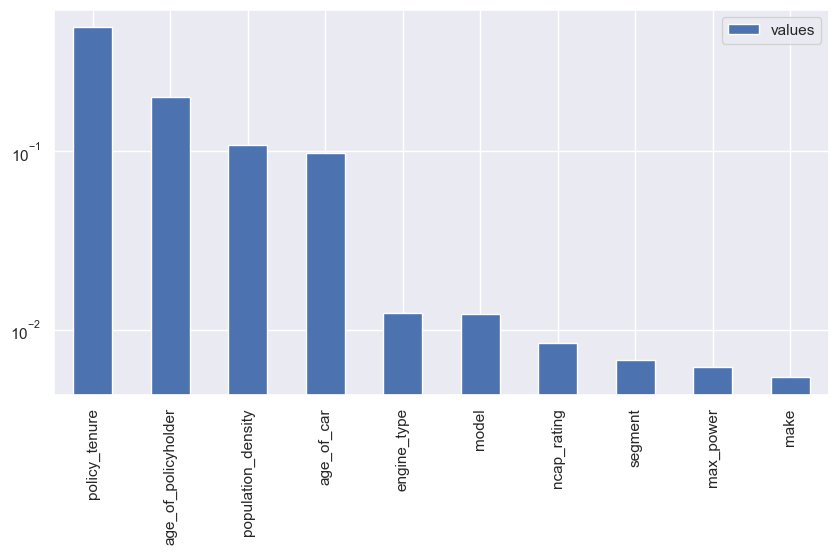

In [15]:
# Create a instance of Decisoin Tree classifier
dtc = DecisionTreeClassifier()
# Fit the data 
dtc=dtc.fit(X_phase1, y)

# List the features sorted in descending order by feature importance and only keeping top 10.
feature_vals=[]
feature_names=[]
features_rank = sorted(zip(dtc.feature_importances_, X_phase1.columns), reverse=True)
for feature in features_rank[:10]:
    feature_vals.append(feature[0])
    feature_names.append(feature[1])

feature_df=pd.DataFrame({'name':feature_names,'values':feature_vals},index=feature_names)
feature_df.plot.bar(figsize=(10,5),log=True)


In [16]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_phase1, y)
# Scale the data using standard scaler
std_scaler=StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_test_scaled=std_scaler.fit_transform(X_test)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     13718
           1       0.07      0.09      0.08       930

    accuracy                           0.87     14648
   macro avg       0.50      0.50      0.50     14648
weighted avg       0.88      0.87      0.87     14648



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

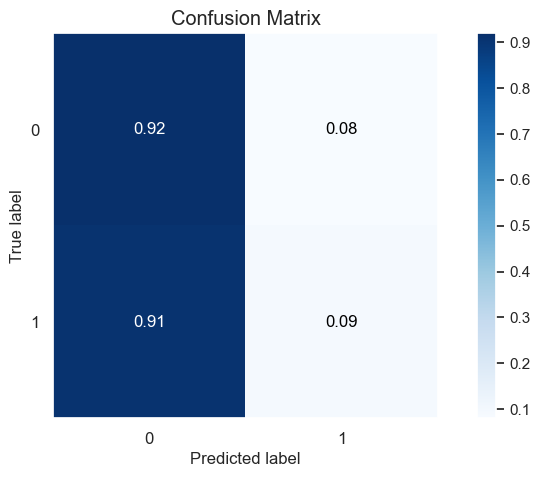

In [17]:
# Intiate the instance of regressor
dtr = TransformedTargetRegressor(regressor=DecisionTreeRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
# Train and test data
dtr = dtr.fit(X_train_scaled, y_train)
y_pred = dtr.predict(X_test_scaled)


#Print classification report
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title = 'Confusion Matrix',figsize=(10,5))

# PHASE 2-Retesting with Sampling

### As we notice above,the model does not perform very well.The model is biased toward one class i.e it only predicts with 7% precesion for class 1.

### In this second phase we will continue the phase 1,perform SMOTEENN sampling technique and retest our model.

In [18]:
# Resampling the data with SMOTEENN
X_sampled,y_sampled=SMOTEENN().fit_resample(X_phase1,y)

In [19]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_phase1, y)
# Scale the data using standard scaler
std_scaler=StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_test_scaled=std_scaler.fit_transform(X_test)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     13723
           1       0.07      0.09      0.08       925

    accuracy                           0.87     14648
   macro avg       0.51      0.51      0.51     14648
weighted avg       0.88      0.87      0.88     14648



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

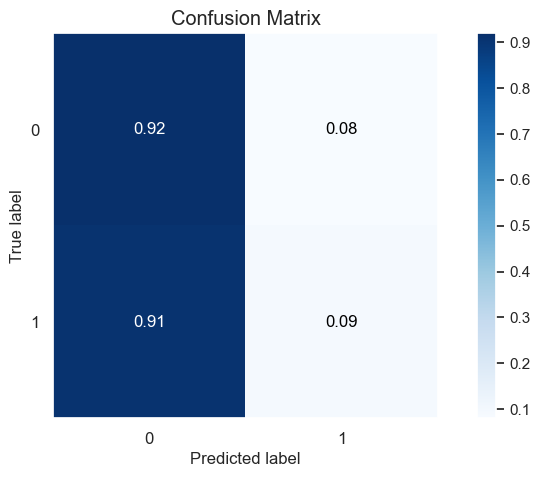

In [20]:
# Intiate the instance of regressor
dtr = TransformedTargetRegressor(regressor=DecisionTreeRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
# Train and test data
dtr = dtr.fit(X_train_scaled, y_train)
y_pred = dtr.predict(X_test_scaled)


#Print classification report
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title = 'Confusion Matrix',figsize=(10,5))

# PHASE 3 - Feature Engineering

### In this phase,we will perform some feature reductions and creating new features.

### For this process,we will combine some features based on their relations with other features and create new feature.
### After that we will perform the phase 2 again i.e perform sampling technqiue on modified features and then test our model.

In [21]:
X=X.copy()
X.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,0.515874,0.05,0.644231,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
1,0.672619,0.02,0.375000,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
2,0.841110,0.02,0.384615,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,0,1,0,0,0,1,0
3,0.900277,0.11,0.432692,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,1,1,1,1,1,1,1,1,1,2
4,0.596403,0.11,0.634615,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,0,0,1,1,1,0,1,1,1,2


In [22]:
X.nunique()

policy_tenure                       58591
age_of_car                             49
age_of_policyholder                    75
population_density                     22
make                                    5
segment                                 6
model                                  11
fuel_type                               3
max_torque                              9
max_power                               9
engine_type                            11
airbags                                 3
is_esc                                  2
is_adjustable_steering                  2
is_tpms                                 2
is_parking_sensors                      2
is_parking_camera                       2
rear_brakes_type                        2
cylinder                                2
transmission_type                       2
gear_box                                2
steering_type                           3
is_rear_window_washer                   2
is_rear_window_defogger           

### As shown above,all the columns starting with "is_" and with 2 unique values are already taken care of in data preprocessing phase above.

### Now,we have to find remainig columns with object data type and group them to create new feature.

In [23]:
# Get list of all the columns with object datatype
column_list = list(X.select_dtypes(include=['O']).columns)
column_list

['segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'rear_brakes_type',
 'transmission_type',
 'steering_type']

### Following are the two steps of grouping different features to create a new feature.

### ['model','segment','make'] --> ['featured_car_details']

### ['max_torque','max_power','engine_type'] --> ['featured_power_range']

<AxesSubplot: title={'center': 'Elbow Plot'}, xlabel='Number of clusters', ylabel='Sum of Squared Errors'>

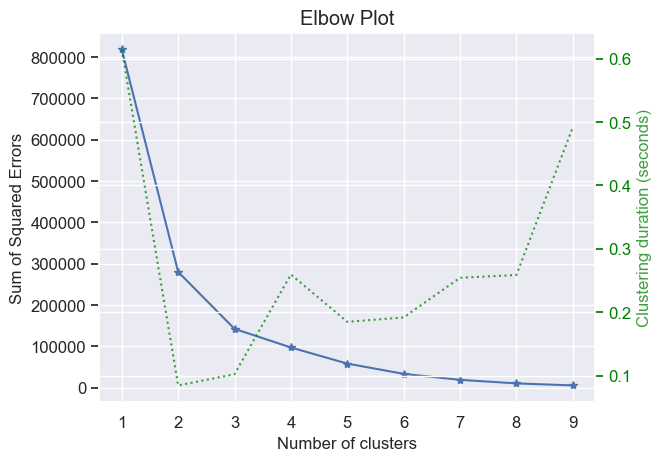

In [24]:
features=['model','segment','make']
for feature in features:
    X[feature] = le.fit_transform(X[feature])
km=KMeans(random_state=0)
km.fit(X[features])

skplt.cluster.plot_elbow_curve(km,X[features], cluster_ranges=range(1, 10))


In [25]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X[features])
X['featured_car_details'] = kmeans.predict(X[features])
X.drop(features,axis=1,inplace=True)
X.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,featured_car_details
0,0.515874,0.05,0.644231,4990,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,0,1,0,0,0,1,0,1
1,0.672619,0.02,0.375000,27003,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,0,1,0,0,0,1,0,1
2,0.841110,0.02,0.384615,4076,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,0,1,0,0,0,1,0,1
3,0.900277,0.11,0.432692,21622,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,1,...,1,1,1,1,1,1,1,1,2,0
4,0.596403,0.11,0.634615,34738,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,0,...,0,1,1,1,0,1,1,1,2,1


### We are performing same steps of clustering as above.Here we are clustering car engine features like torque,power and engine type.

<AxesSubplot: title={'center': 'Elbow Plot'}, xlabel='Number of clusters', ylabel='Sum of Squared Errors'>

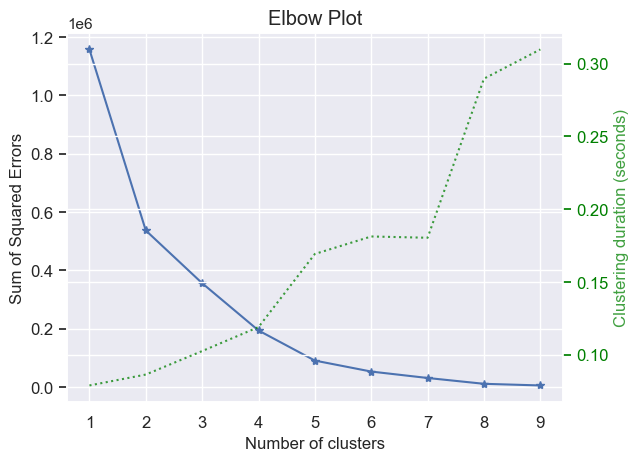

In [26]:
features=['max_torque','max_power','engine_type']
for feature in features:
    X[feature] = le.fit_transform(X[feature])
km=KMeans(random_state=0)
km.fit(X[features])

skplt.cluster.plot_elbow_curve(km,X[features], cluster_ranges=range(1, 10))

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X[features])
X['featured_power_range'] = kmeans.predict(X[features])
X['featured_power_range']
X.drop(features,axis=1,inplace=True)
X.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,fuel_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,featured_car_details,featured_power_range
0,0.515874,0.05,0.644231,4990,CNG,2,0,0,0,1,...,0,0,1,0,0,0,1,0,1,2
1,0.672619,0.02,0.375000,27003,CNG,2,0,0,0,1,...,0,0,1,0,0,0,1,0,1,2
2,0.841110,0.02,0.384615,4076,CNG,2,0,0,0,1,...,0,0,1,0,0,0,1,0,1,2
3,0.900277,0.11,0.432692,21622,Petrol,2,1,1,0,1,...,1,1,1,1,1,1,1,2,0,3
4,0.596403,0.11,0.634615,34738,Petrol,2,0,0,0,0,...,1,1,1,0,1,1,1,2,1,3


In [28]:
ohe_cols=list(X.select_dtypes(include=['O']).columns)
print(ohe_cols)

['fuel_type', 'rear_brakes_type', 'transmission_type', 'steering_type']


### ohe_cols is the list of remaining categorical columns which we are encoding using One-hot encoding method as per our encoding strategy.

In [29]:
# Create a dataframe of One hot encodng features
ohe_df=pd.get_dummies(X[ohe_cols])

# Merge df with X
X=pd.concat([X, ohe_df], axis=1)

# Drop the original columns
X=X.drop(columns=ohe_cols)
X.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,...,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,rear_brakes_type_Disc,rear_brakes_type_Drum,transmission_type_Automatic,transmission_type_Manual,steering_type_Electric,steering_type_Manual,steering_type_Power
0,0.515874,0.05,0.644231,4990,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
1,0.672619,0.02,0.375000,27003,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
2,0.841110,0.02,0.384615,4076,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
3,0.900277,0.11,0.432692,21622,2,1,1,0,1,1,...,0,0,1,0,1,1,0,1,0,0
4,0.596403,0.11,0.634615,34738,2,0,0,0,0,1,...,0,0,1,0,1,1,0,1,0,0


In [30]:
# computing number of rows
rows = len(X.axes[0])
# computing number of columns
cols = len(X.axes[1])
print("Number of Rows: ", rows)
print("Number of Columns: ", cols)

Number of Rows:  58592
Number of Columns:  35


In [31]:
Counter(y)

Counter({0: 54844, 1: 3748})

<AxesSubplot: >

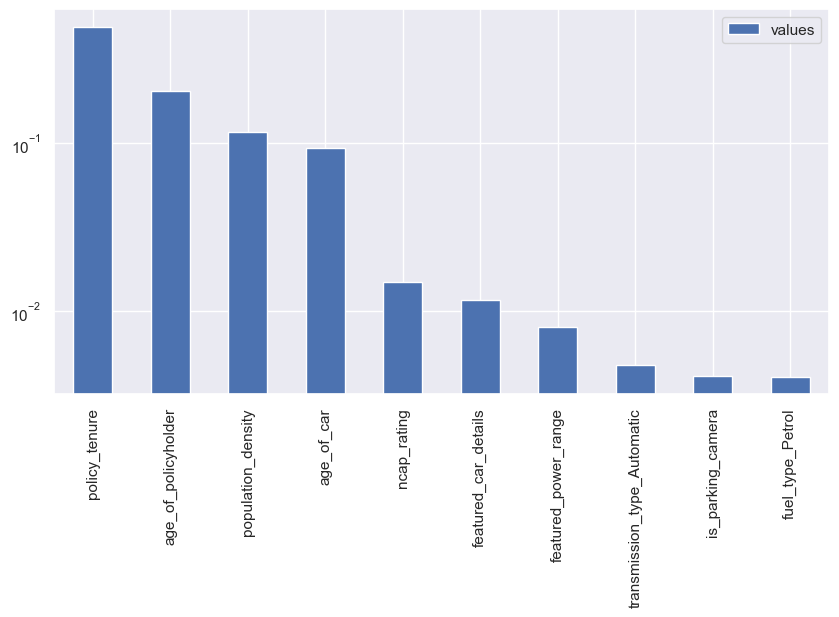

In [32]:
# Initializing the classifier
dtc = DecisionTreeClassifier()
# Fit the classifier on X and y data
dtc=dtc.fit(X, y)

# List the features sorted in descending order by feature importance and kepping only top 10 features.
feature_vals=[]
feature_names=[]
features_rank = sorted(zip(dtc.feature_importances_, X.columns), reverse=True)
for feature in features_rank[:10]:
    feature_vals.append(feature[0])
    feature_names.append(feature[1])

feature_df=pd.DataFrame({'name':feature_names,'values':feature_vals},index=feature_names)
feature_df.plot.bar(figsize=(10,5),log=True)


In [33]:
# Resampling the data
X_sampled,y_sampled=SMOTEENN().fit_resample(X,y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8338
           1       0.92      0.94      0.93     10119

    accuracy                           0.92     18457
   macro avg       0.92      0.92      0.92     18457
weighted avg       0.92      0.92      0.92     18457



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

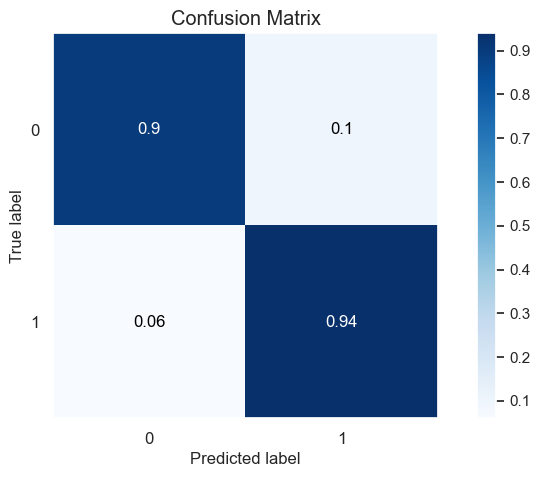

In [34]:
# Fit,train and test the model
dtr = TransformedTargetRegressor(regressor=DecisionTreeRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
dtr = dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title = 'Confusion Matrix',figsize=(10,5))

# Phase 4 - Only using top 10 features

In [35]:
# Keeping only top features
X=X[feature_names]

# Resampling the data
X_sampled,y_sampled=SMOTEENN().fit_resample(X,y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled)


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8218
           1       0.92      0.94      0.93     10322

    accuracy                           0.92     18540
   macro avg       0.92      0.92      0.92     18540
weighted avg       0.92      0.92      0.92     18540



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

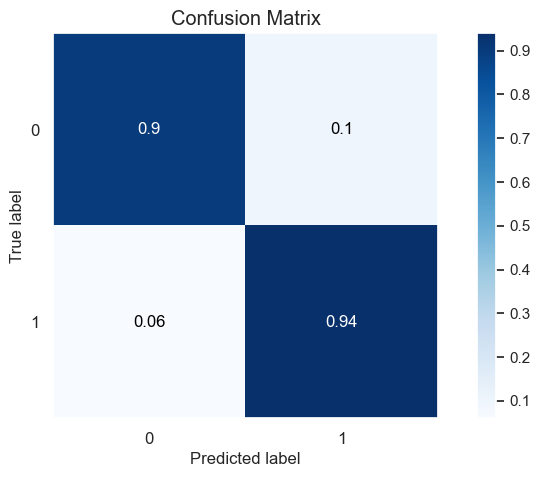

In [36]:
# Fit,train and test the model
dtr = TransformedTargetRegressor(regressor=DecisionTreeRegressor(), transformer=QuantileTransformer(output_distribution='normal'))
dtr = dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title = 'Confusion Matrix',figsize=(10,5))